In [2]:
import torch
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch.nn.functional as F
import rl_utils
import copy

In [3]:
### GAE implementation
def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float) # shape: [time_step, 1] advantage for (s_t, a_t)

In [4]:
### Net
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [5]:
### TRPO
class TRPOAgent:
    def __init__(self,
                 hidden_dim,
                 state_space,
                 action_space,
                 lmbda,
                 kl_constraint,
                 alpha,
                 critic_lr,
                 gamma,
                 device):
        state_dim = state_space.shape[0]
        action_dim = action_space.n
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.lmbda = lmbda
        self.kl_constraint = kl_constraint
        self.alpha = alpha
        self.gamma = gamma
        self.device = device
        
    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def hessian_matrix_vector_product(self, states, old_action_dists, vector):
        # states: [time_step, state_dim]
        # actor(states): [time_step, action_dim] indicates the probability of each action
        new_action_dists = torch.distributions.Categorical(self.actor(states))
        kl = torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists).mean()
        kl_grads = torch.autograd.grad(kl, self.actor.parameters(), create_graph=True)
        kl_grads_vector = torch.cat([grad.view(-1) for grad in kl_grads])
        # dot multiply of KL gradient and input vector
        kl_grads_vector_product = torch.dot(kl_grads_vector, vector)

        grad2 = torch.autograd.grad(kl_grads_vector_product, self.actor.parameters())
        grad2_vector = torch.cat([grad.view(-1) for grad in grad2])
        return grad2_vector
    
    def conjugate_gradient(self, grad, states, old_action_dists):
        x = torch.zeros_like(grad)
        r = grad.clone()
        p = grad.clone()
        rdotr = torch.dot(r, r)
        for i in range(10):
            Hp = self.hessian_matrix_vector_product(states, old_action_dists, p)
            alpha = rdotr / torch.dot(p, Hp)
            x += alpha * p
            r -= alpha * Hp
            new_rdotr = torch.dot(r, r)
            if new_rdotr < 1e-10: # convergence
                break
            beta = new_rdotr / rdotr
            p = r + beta * p
            rdotr = new_rdotr
        return x
    
    def line_search(self, states, actions, advantage, old_log_probs,
                    old_action_dists, max_vec):
        old_para = torch.nn.utils.convert_parameters.parameters_to_vector(self.actor.parameters())
        old_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, self.actor)
        
        for i in range(15):
            coef = self.alpha**i
            new_para = old_para + coef * max_vec
            new_actor = copy.deepcopy(self.actor)
            torch.nn.utils.convert_parameters.vector_to_parameters(new_para, new_actor.parameters())
            new_action_dists = torch.distributions.Categorical(new_actor(states))
            kl_div = torch.mean(torch.distributions.kl.kl_divergence(old_action_dists, new_action_dists))
            new_obj = self.compute_surrogate_obj(states, actions, advantage, old_log_probs, new_actor)
            if new_obj > old_obj and kl_div < self.kl_constraint: # satisfy both conditions
                return new_para
        return old_para

    def compute_surrogate_obj(self, states, actions, advantages, old_log_probs, actor):
        # states: [time_step, state_dim]
        # actor(states): [time_step, action_dim]
        # actions: [time_step, 1]
        # ratio: [time_step, 1]
        log_probs = torch.log(actor(states).gather(1, actions)) # get log prob of pair (s,a), log for numerical stability
        ratio = torch.exp(log_probs - old_log_probs) # importance sampling ratio
        surrogate_obj = (ratio * advantages).mean() # [time_step, 1] -> [1]
        return surrogate_obj

    def policy_learn(self, states, actions, old_action_dists, advantages, old_log_probs):
        surrogate_obj = self.compute_surrogate_obj(states, actions, advantages, old_log_probs, self.actor) # get the value of surrogate obj
        grads = torch.autograd.grad(surrogate_obj, self.actor.parameters()) # get the gradient "g" of surrogate obj by params of actor
        obj_grad = torch.cat([g.view(-1) for g in grads]).detach() # flatten the gradient "g" to a vector
        # although obj_grad does not participate in gradient calculation
        # keep .detach() to avoid potential issues in subsequent numerical computations, also save memory

        descent_direction = self.conjugate_gradient(obj_grad, states, old_action_dists) # get the descent direction "x" by solving Hx = g
        # Hd is "Hx" in the formula
        # why not use obj_grad here? maybe for numerical stability
        Hd = self.hessian_matrix_vector_product(states, old_action_dists, descent_direction)

        # max update step length
        max_coef = torch.sqrt(2 * self.kl_constraint / (torch.dot(descent_direction, Hd) + 1e-8))

        new_para = self.line_search(states,
                                    actions,
                                    advantages,
                                    old_log_probs,
                                    old_action_dists,
                                    descent_direction * max_coef)
        torch.nn.utils.convert_parameters.vector_to_parameters(new_para, self.actor.parameters())

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)

        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones) # shape: [time_step, 1]
        td_delta = td_target - self.critic(states)
        advantages = compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)

        # like target net in DQN, dont pass gradient
        critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        old_action_dists = torch.distributions.Categorical(self.actor(states).detach())
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach() # shape: [time_step, 1]
        self.policy_learn(states, actions, old_action_dists, advantages, old_log_probs)

Iteration 9: 100%|██████████| 50/50 [00:02<00:00, 19.15it/s, episode=500, return=161.900]


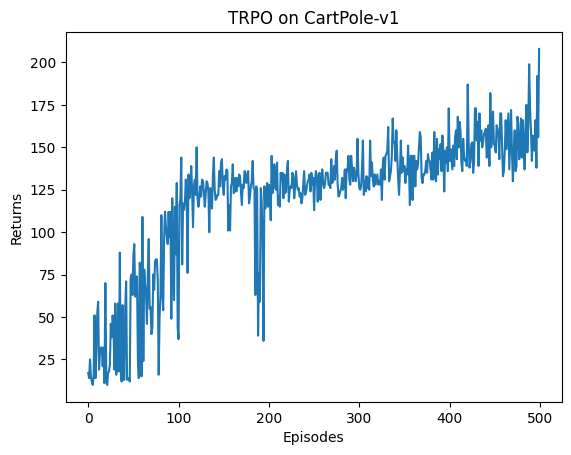

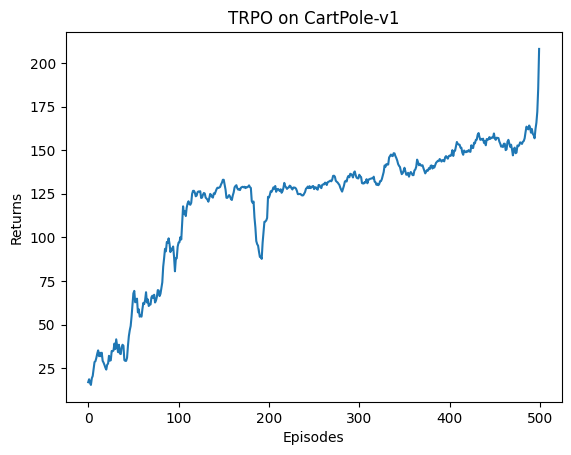

In [7]:
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
critic_lr = 1e-2
kl_constraint = 0.0005
alpha = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.observation_space.seed(0)
env.action_space.seed(0)
np.random.seed(0)
torch.manual_seed(0)
agent = TRPOAgent(hidden_dim, env.observation_space, env.action_space, lmbda,
             kl_constraint, alpha, critic_lr, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('TRPO on {}'.format(env_name))
plt.show()